## 平面数据的分类

### 需要的库

这里需要导入的库有：

- numpy：这个不用介绍
- sklearn  这是一个机器学习库，这里主要用来导入需要训练的数据
- matplotlib 不用介绍
- testCases 用来测试各种函数
- planar_utils 主要用来导入数据

In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # 设置一个种子保证结果的一致性

### 数据加载

这里主要加载的是一个2维的平面数据，利用提供的planar_utils来获得,这里有两个类，其类型的排布我们可以用散点图绘制出来。
- X是一个二维的数据（x0,x1）其排布有点像花瓣一样
- Y是表示类型0-1两种类型

数据的个数有400个


(2, 400)
(1, 400)
400


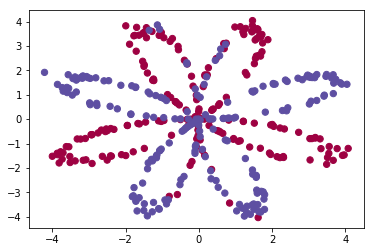

In [12]:
X,Y = load_planar_dataset()

shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]
print(X.shape)
print(Y.shape)
print(m)

plt.scatter(X[0,:],X[1,:],c=np.squeeze(Y),s=40,cmap=plt.cm.Spectral)

### 使用简单的逻辑回归模型

这里我们仅仅通过logistic regression来做分类，主要是使用sklearn这个库中自带的方法来进行分类。具体函数如下：

In [13]:
# 创建一个线性的逻辑回归模型
clf = sklearn.linear_model.LogisticRegressionCV()
#训练该模型
clf.fit(X.T,Y.T)

D:\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

测试的精度为：0.470000


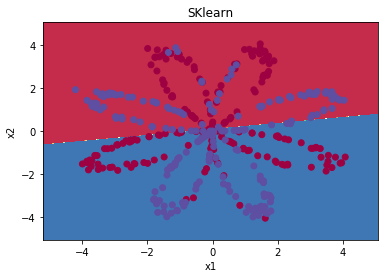

In [21]:
# 
plot_decision_boundary(lambda  x:clf.predict(x),X,np.squeeze(Y))
plt.title("SKlearn")

LR_predictions = clf.predict(X.T)
acc = float(np.sum(LR_predictions==Y))/float(Y.size)
print("测试的精度为：%f" % acc)

### 使用两层的神经网络模型（单个隐含层）


上面的例子可以看出，如果仅仅只是使用单单的sigmoid函数分类，其结果不是很理想，因为其仅仅只能作为一条线的分割。无法做到全类型的分割。所以这里我们需要使用神经网络的方法来实现。这里我们仅仅介绍使用单个隐含层来做处理。
其模型的结构如下：
![](imgs/1.jpg)

上图中的流程可以归纳的数学式子如下：

![](imgs/2.jpg)

为了实现上面的模型的，我们需要做如下工作：

- 定义模型结构：隐含层层数，隐含层的个数
- 参数初始化
- 循环
    - 前向传播，预测函数
    - 损失值计算
    - 反向传播，计算梯度
    - 更新参数

#### 定义模型结构

这里定义2层的神经网络模型
- n_x: 输入层的size，可以通过输入的值确定
- n_h: 隐层层的个数
- n_y: 输出层的size，可以通过输出值确定


In [3]:
# 导入时数据，确定输入和输出的值
X,Y = load_planar_dataset()

print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


In [4]:
def layer_siez(X,Y):
    """
        X,Y:输入输出的值
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return n_x,n_h,n_y

#### 初始化参数

这里需要注意以下几个点：
- 参数的size是否正确：这个需要我们分析W,b的size,其实很好判断，就是根据前面的输出和后面输入来判断
- W权重参数可以使用符合高斯分布的随机数进行初始化：np.random.rand()*0.01
- b偏置值参数直接复制为0

具体操作如下：

In [5]:
def init_para(n_x,n_h,n_y):
    """
    n_x,n_h,n_y:各个层的数据维度
    """
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters={
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    
    return parameters
    

### 前向传播

这里需要注意的几点是，我们需要自己定义sigmoid函数，这个很简单,
这里我们第一层用到了tanh作为激活函数，可以直接使用numpy自带的函数来实现。

In [6]:
def sigmiod(x):
    return 1.0/1+np.exp(-x)

In [ ]:
def forward(X,parameters):
    """
        前向传播，也叫推理
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
    
    # 这里简单的判断一下
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1":Z1,
        "A1":A1,
        "Z2":Z2,
        "A2":A2
    }
    
    return A2,cache
    
    

### 损失函数

我们这里选用交叉熵函数（cross_entropy）来计算损失值.

In [10]:
def  compute_loss(A2,Y,parameter):
    
    # 获得批量数据的个数
    m = Y.shape[1]
    
    # 这里使用numpy的乘法公式
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),(1-Y))
    # numpy sum函数进行计算
    cost = np.sum(logprobs) /m
    
    # 将cost的参数转为正确的size格式，[[12]] = >[12]
    cost = np.squeeze(cost)
    
    assert(isinstance(cost, float))
    
    return cost
        
    